# Animas River basin time series
---  
*J. Michelle Hu  
University of Utah  
Oct 2024*  


In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
import seaborn as sns

from pathlib import PurePath
from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

# Set seaborn palette
sns.set_palette('icefire')

# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem

pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ'] = pyprojdatadir
os.environ['PROJLIB'] = pyprojdatadir
os.environ['PROJ_LIB'] = pyprojdatadir

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/studio/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


In [2]:
%reload_ext autoreload
%autoreload 2

### Env setup

### Directories and global variables

In [3]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts'
poly_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys'
aso_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO'

# SNOTEL all sites geojson fn - snotel site json
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SNOTEL/snotel_sites_32613.json'

# nwm proj4 file
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/NWM_datasets_proj4.txt"

In [4]:
# Basin-specific variables
basin = 'animas'

# Select just for all variable output of time decay
basindirs = h.fn_list(workdir, f'*{basin}*/wy*/{basin}*/')

# Get the WY from the directory name - assumes there is only one WY per basin right now
WYs = [int(basindir.split('wy')[1][:4]) for basindir in basindirs]
WYs = np.unique(WYs)
if len(WYs) == 1:
    WY = WYs[0]
else:
    print(f'Multiple water years in {basin} basin: {WYs}')
print(WY)

# Figure out filenames
poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]
print(poly_fn)

2021
/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts/animas_setup/polys/animas_basin_outline_HUC10_32613.shp


# Evaluate snow depth

### SNOTEL extraction and point specification
- identify SNOTEL sites within the specified basin
- extract site metadata (site name, site number, and coordinates)
- extract snow depth values for WY of interest

In [5]:
# Locate SNOTEL sites within basin
found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn)

# Get site names and site numbers
sitenames = found_sites['site_name']
sitenums = found_sites['site_num']
print(sitenames)

ST_arr = ['CO'] * len(sitenums)
gdf_metloom, snotel_dfs = proc.get_snotel(sitenums, sitenames, ST_arr, WY=WY)
gdf_metloom

148           Cascade #2 (387)
199        Mineral Creek (629)
200           Molas Lake (632)
213    Red Mountain Pass (713)
225        Spud Mountain (780)
Name: site_name, dtype: object


,geometry
0,POINT (252750.215 4171512.574)
1,POINT (260096.558 4192384.457)
2,POINT (263060.449 4181404.536)
3,POINT (261355.538 4197269.475)
4,POINT (255044.367 4176033.969)


<Axes: xlabel='datetime'>

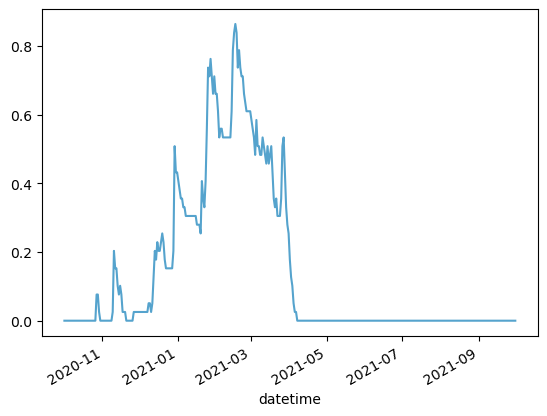

In [6]:
snotel_dfs[sitenames.iloc[0]]["SNOWDEPTH_m"].plot(label=f'SNOTEL {sitenames.iloc[0]}')

In [7]:
# Hold off on writing out for now. this is still pretty quick but may pose an issue if the wcc site is down

In [8]:
# import hvplot.pandas
# import hvplot.xarray
# pd.options.plotting.backend = 'holoviews'

# snotelplt = snotel_dfs[sitenames.iloc[0]]["SNOWDEPTH_m"].hvplot(label=f'SNOTEL {sitenames.iloc[0]}')
# snotelplt

### NWM
  
Processed using extract_nwm_timeseries_point.py animas 2021 script to minimize extraction and transformation

<Axes: xlabel='Date'>

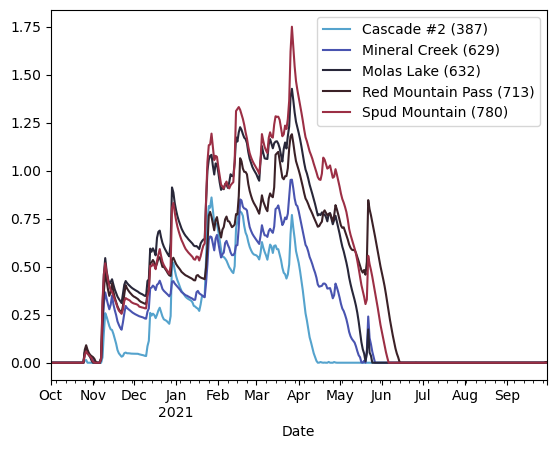

In [9]:
nwm_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/NWM/'
nwm_csv = h.fn_list(nwm_dir, f'{basin}/*.csv')[0]
nwm_df = pd.read_csv(nwm_csv, index_col=0)
nwm_df.index.name = 'Date'
# Set as DatetimeIndex
nwm_df.index = pd.to_datetime(nwm_df.index)
nwm_daily_df = nwm_df.resample('1D').mean()
nwm_daily_df.plot()

In [10]:
# Old way
# # Read in NWM proj4 string
# with open(proj_fn, "r") as f:
#     proj4 = f.read()
#     print(proj4)

# # Convert snotel points to NWM projection to extract time series
# gdf_metloom_nwm = gdf_metloom.to_crs(crs=proj4)

# # Use gdf_metloom in nwm coords to extract NWM data
# nwm_ds = proc.get_nwm_retrospective_LDAS(gdf_metloom_nwm, 
#                                          start=f'{WY-1}-10-01', 
#                                          end=f'{WY}-09-30', var='SNOWH')

# gdf_metloom_nwm.bounds
# nwmplt = nwm_ds[0].plot(label='NWM SNOWH')
# nwmplt
# # Combined!
# snotelplt.opts(line_dash='dashdot', color='dimgray') 
# nwmplt.opts(line_dash='solid', color='#c071fe') # equivalent of 'xkcd:easter purple'
# combined = snotelplt * nwmplt
# combined.opts(height=400, width=1000, title=f'{sitenames.iloc[0]} snow depth') 

### SWANN

In [11]:
# TODO - Very low priority to turn this into a script. Doesn't take long as is

/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SWANN_SWE_depth/animas/animas_swann_snotelmetloom_DEPTH_wy2021.csv
CPU times: user 214 ms, sys: 1.96 ms, total: 216 ms
Wall time: 217 ms


<Axes: xlabel='Date'>

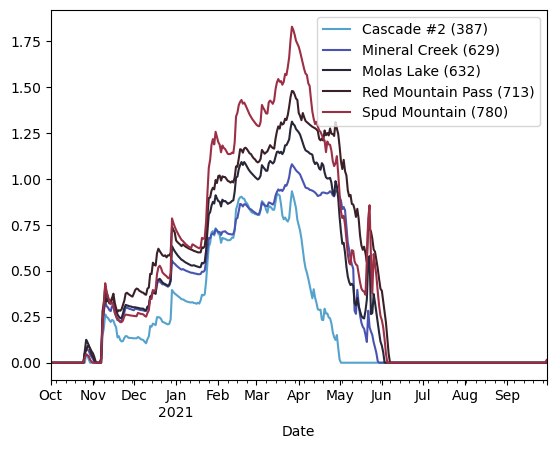

In [12]:
%%time
# SWANN dir
swann_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SWANN_SWE_depth'

# Establish filename of time series based on this WY (netcdf much smaller than csv)
swann_ts_fn = f'{swann_dir}/{basin}/{basin}_swann_snotelmetloom_DEPTH_wy{WY}.csv'
print(swann_ts_fn)

# If this file does not exist, process
if not os.path.exists(swann_ts_fn):
    # Get this water year's file
    swann_wy_fn = h.fn_list(swann_dir, f'*{WY}*')
    
    # Read in the depth variable
    swann_ds = xr.open_mfdataset(swann_wy_fn, drop_variables=["SWE", "time_str"])
    
    # Reassign coordinate names 
    swann_ds = swann_ds.rename({'lat': 'y', 'lon': 'x'})
    
    # Explicitly write out crs
    swann_ds.rio.write_crs(input_crs=swann_ds.crs.attrs['spatial_ref'],
                           inplace=True)
    
    # Transform  the x and y coords of snotel sites into this SWANN dst_crs
    gdf_metloom_reproj = gdf_metloom.to_crs(swann_ds.crs.attrs['spatial_ref'])
    
    # Extract values at snotel coordinates
    swann_data = swann_ds['DEPTH'].sel(x=list(gdf_metloom_reproj.geometry.x.values), 
                                       y=list(gdf_metloom_reproj.geometry.y.values), 
                                       method='nearest')
        
    # Convert to a dict and convert depth from millimeters to meters
    swann_dict = dict()
    for jdx, sitename in enumerate(sitenames):
        ds = swann_data[:, jdx, jdx]
        swann_dict[sitename] = ds.values / 1000

    # Turn it into a dataframe
    swann_datadf = pd.DataFrame(swann_dict, index=ds['time'].values)

    # Save the the dataframe as csv for easy access later
    if not os.path.exists(swann_ts_fn):
        swann_basin_dir = f'{swann_dir}/{basin}'
        if not os.path.exists(swann_basin_dir):
            os.makedirs(swann_basin_dir)
    
    # Write out for next time
    swann_datadf.to_csv(swann_ts_fn)

else:
    swann_datadf = pd.read_csv(swann_ts_fn, index_col=0)
    swann_datadf.index.name = 'Date'
    # Set as DatetimeIndex
    swann_datadf.index = pd.to_datetime(swann_datadf.index)
    
swann_datadf.plot()

### iSnobal output extraction

- iSnobal time decay
- iSnobal HRRR-MODIS

In [13]:
labels = ['iSnobal-HRRR', 'HRRR-MODIS']
# Need to re-run time decay?

In [14]:
figsize = (18, 4)
linestyles = ['-', '--']
linewidth = 1
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']
isnobalcolors = ['k', 'coral']

In [15]:
# %%time
# # currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
# month = 'run20'
# varname = 'snow'

# days = dict()
# for label, basindir in zip(labels, basindirs):
#     basin_days = h.fn_list(basindir, f"{month}*/{varname}.nc")
#     days[label] = basin_days
    
# for d in days.keys():
#     print(d)
#     print(len(days[d]))

In [16]:
# %%time
# # extract the snow state variables for the selected sites
# ds_dict = dict()
# chunks = 'auto'
# # snow.nc contains these variables as well that we will drop
# drop_var_list = ['snow_density', 'specific_mass', 'liquid_water', 'temp_surf', 'temp_lower', 'temp_snowcover', 'thickness_lower', 'water_saturation', 'projection']
# thisvar = 'thickness'

# for label in days.keys():
#     ds_list = [xr.open_dataset(day_fn, chunks=chunks, drop_variables=drop_var_list) for day_fn in days[label]]
#     snow_var_data = [ds[thisvar].sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest') for ds in ds_list]
#     snow_var_data = xr.concat(snow_var_data, dim='time')
#     ds_dict[f'{label}_{thisvar}'] = snow_var_data

In [17]:
%%time
# Takes about 2.5 min
chunks = 'auto'

# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
varname = 'snow'

# snow.nc contains these variables as well that we will drop
drop_var_list = ['snow_density', 'specific_mass', 'liquid_water', 'temp_surf', 'temp_lower', 'temp_snowcover', 'thickness_lower', 'water_saturation', 'projection']
thisvar = 'thickness'

ds_dict = dict() 

for kdx, label in enumerate(labels):
    model_ts_fn = f'{PurePath(basindirs[0]).parents[0].as_posix()}/{basin}_{label}_{thisvar}_snotelmetloom_wy{WY}.csv'
    print(model_ts_fn)

    if not os.path.exists(model_ts_fn):
        print("^^DNE, calculating...")
        days = dict()
        basindir = basindirs[kdx]
        basin_days = h.fn_list(basindir, f"{month}*/{varname}.nc")
        days[label] = basin_days

        for d in days.keys():
            print(d)
            print(len(days[d]))

        # extract the snow state variables for the selected sites
        ds_list = [xr.open_dataset(day_fn, chunks=chunks, drop_variables=drop_var_list) for day_fn in days[label]]
        snow_var_data = [ds[thisvar].sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest') for ds in ds_list]
        snow_var_data = xr.concat(snow_var_data, dim='time')
        ds_dict[f'{label}_{thisvar}'] = snow_var_data

        # Turn these into dataframes and write to csvs
        basin_dict = dict()
        for jdx, sitename in enumerate(sitenames):
            ds = ds_dict[f'{label}_{thisvar}'][:, jdx, jdx]
            basin_dict[sitename] = ds.values

        # Turn it into a dataframe
        basin_df = pd.DataFrame(basin_dict, index=ds['time'].values)
        print(model_ts_fn)

        # Save the the dataframe as csv for easy access later
        basin_df.to_csv(model_ts_fn)
    else:
        df = pd.read_csv(model_ts_fn, index_col=0)
        df.index.name = 'Date'
        # Set as DatetimeIndex
        df.index = pd.to_datetime(df.index)
        ds_dict[f'{label}_{thisvar}'] = df

/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/animas_100m_isnobal/wy2021/animas_iSnobal-HRRR_thickness_snotelmetloom_wy2021.csv
/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/animas_100m_isnobal/wy2021/animas_HRRR-MODIS_thickness_snotelmetloom_wy2021.csv
CPU times: user 10.4 ms, sys: 1.07 ms, total: 11.4 ms
Wall time: 11.8 ms


CPU times: user 849 ms, sys: 0 ns, total: 849 ms
Wall time: 854 ms


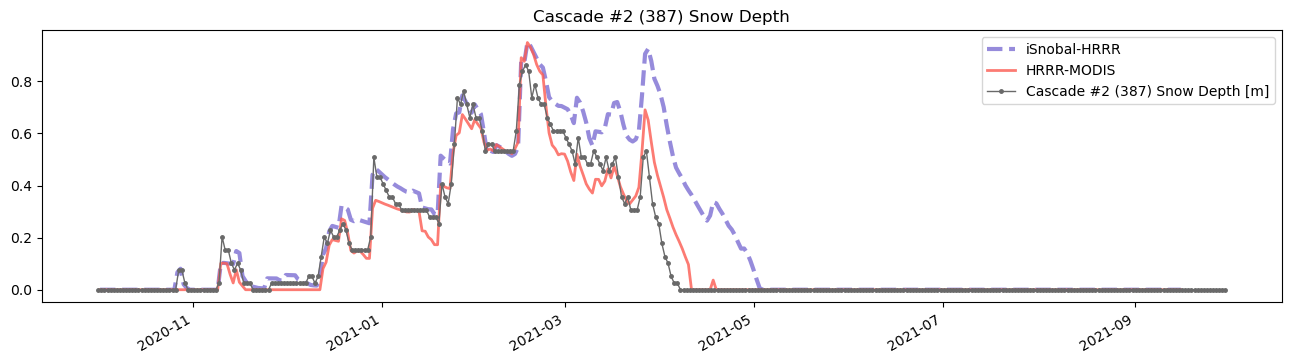

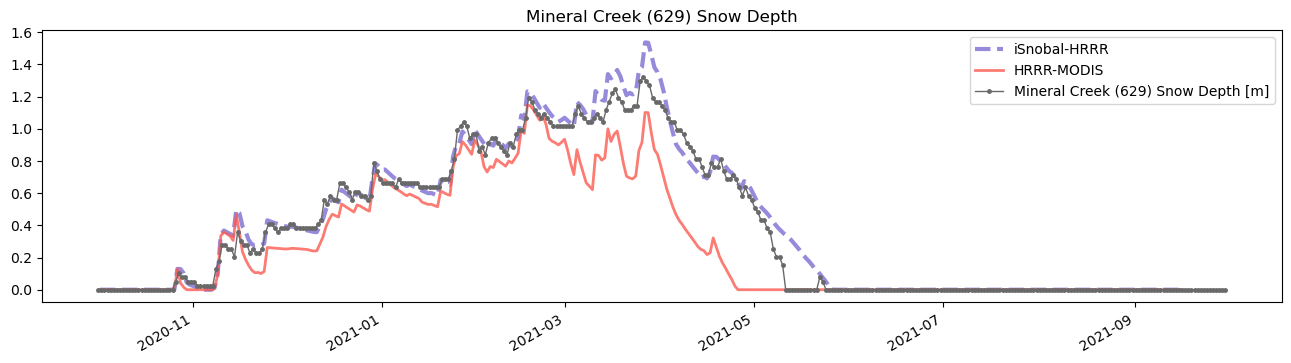

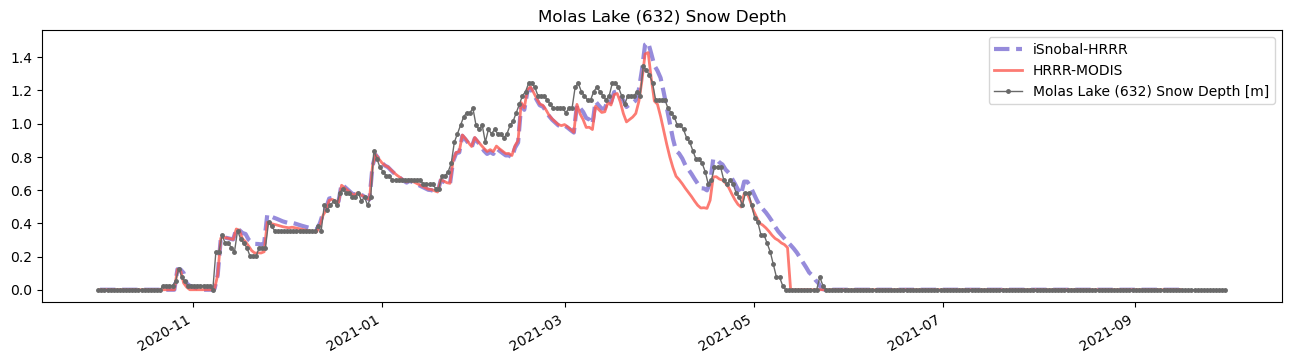

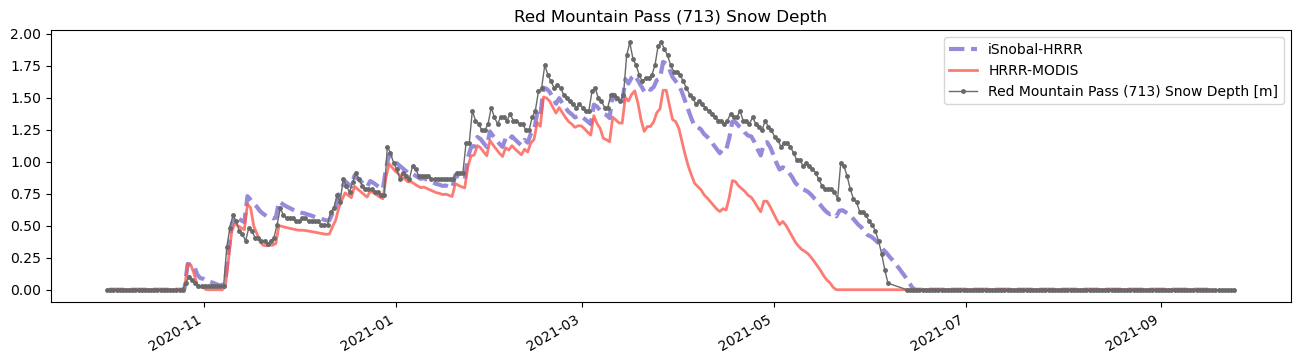

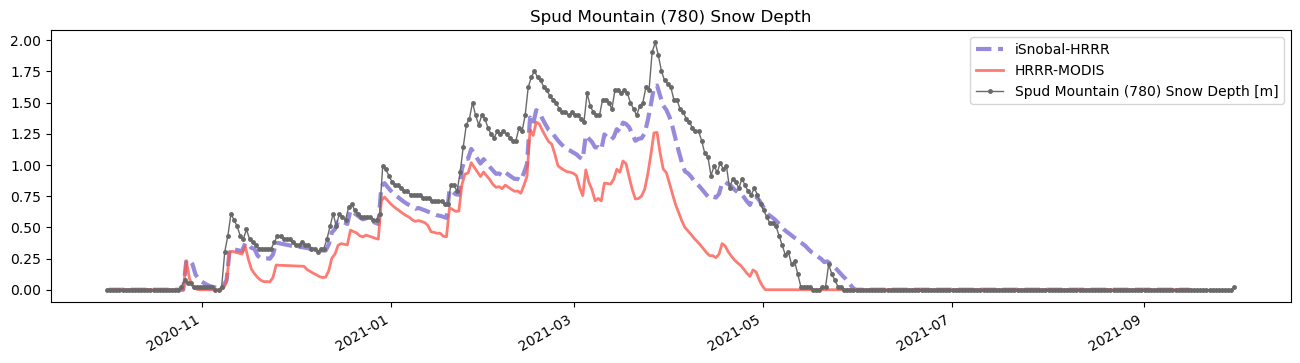

In [18]:
%%time
colors = ['slateblue', 'xkcd:coral']
linestyles = ['--', '-']
linewidths = [3, 2]
alphas = [0.7, 0.8]
for kdx, sitename in enumerate(sitenames):
    fig, ax = plt.subplots(1, figsize=(16, 4))
    for mdx, label in enumerate(labels):
        snow_var_data = ds_dict[f'{label}_{thisvar}']
        snow_var_data[sitename].plot(ax=ax, color=colors[mdx], 
                                        label=label, linewidth=linewidths[mdx], 
                                        linestyle=linestyles[mdx], alpha=alphas[mdx]
                                       )

        
    # Plot WY time series of snow depth
    (snotel_dfs[f'{sitename}']['SNOWDEPTH_m']).plot(ax=ax, label=f'{sitename} Snow Depth [m]', 
                                                    linestyle='-', linewidth=1, color='dimgray',
                                                    marker='.', markersize=5
                                                   )
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(f'{sitename} Snow Depth')
    plt.xlabel('');

### ASO value extraction

/uufs/chpc.utah.edu/common/home/skiles-group3/ASO/CO/ASO_Animas_Mosaic_2021Apr19_snowdepth_50m.tif
/uufs/chpc.utah.edu/common/home/skiles-group3/ASO/CO/ASO_Animas_Mosaic_2021May15-16_snowdepth_50m.tif
['20210419', '20210516']
EPSG:32613
site_name   Cascade #2 (387)  Mineral Creek (629)  Molas Lake (632)  \
2021-04-19               0.0             0.575357          0.422410   
2021-05-16               0.0             0.028073          0.018803   

site_name   Red Mountain Pass (713)  Spud Mountain (780)  
2021-04-19                 1.171395             0.887752  
2021-05-16                 0.649943             0.206266  
CPU times: user 930 ms, sys: 255 ms, total: 1.19 s
Wall time: 1.29 s


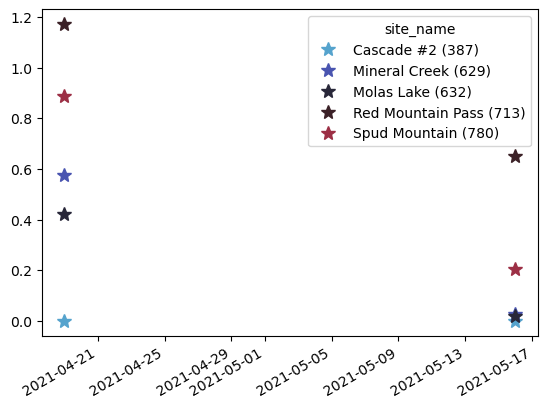

In [19]:
%%time
# Locate ASO snow dpeth files
state = 'CO'

# from https://nsidc.org/sites/nsidc.org/files/technical-references/ASO_Basins.pdf
# only blue river basin has different names
basin_name = basin.capitalize() # more recent collections

# Water year collections should all be post January so this should work
# depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*{WY}*tif')
depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*snowdepth*tif')
if len(depth_fns) == 0:
    depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*/*{basin_name}*snowdepth*tif')
    if len(depth_fns) == 0:
        depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*tif')

_ = [print(f) for f in depth_fns]

# Load depth arrays and squeeze out single dimensions
depth_list = [np.squeeze(xr.open_dataset(fn, chunks=chunks)) for fn in depth_fns]

# Rename band_data to be more descriptive
depth_list = [ds.rename_vars({'band_data': 'snow_depth'}) for ds in depth_list]

# Deal with adding time input for ASO data
inputvar = '_snowdepth'
# inputvar = '.'
depth_list = [np.squeeze(proc.assign_dt(ds, proc.extract_dt(fn, inputvar=inputvar))) for ds, fn in zip(depth_list, depth_fns)]

# Get dates, could easily just pull from filenames, but this is fine
date_list = [proc.extract_dt(fn, inputvar=inputvar)[0] for fn in depth_fns]
date_list = [f.strftime('%Y%m%d') for f in date_list]
print(date_list)

# ASO is in EPSG 32613 for USCOBR, same as gdf_metloom. Should be good to go
print(depth_list[0].rio.crs)

# Extract ASO snow depth value with NN lookup at snotel sites
aso_sd_point_list = [] 

for ds in depth_list:
    # Extract data value from this point based on nearest neighbor lookup (inexact)
    # Coords must be bracketed
    aso_sd_point = ds['snow_depth'].sel(x=list(gdf_metloom.geometry.x.values),
                                       y=list(gdf_metloom.geometry.y.values), 
                                       method='nearest')
    aso_sd_point_list.append(aso_sd_point)

# Concatenate the list of data arrays into a single dataarray based on time dimension
aso_depth_ts = xr.concat(aso_sd_point_list, dim='time')

# Extract into individual time series
aso_site_ts_list = []
for jdx, sitenum in enumerate(sitenums):
    # print(jdx)
    aso_site_ts = aso_depth_ts[:, jdx, jdx]
    aso_site_ts_list.append(aso_site_ts)

# Generate dates for ASO data dataframe
aso_dt_list = [depth['time'].values for depth in aso_sd_point_list]

# Put the extracted depths into a dataframe
aso_depth_ts_df = pd.DataFrame(data=np.array(aso_site_ts_list).T, columns=sitenames, index=aso_dt_list)
print(aso_depth_ts_df)

# aso_depth_ts_df.plot(kind='scatter', title='ASO')
aso_depth_ts_df.plot(linewidth=0, markersize=10, marker='*');

In [20]:
%%time
# Extract ASO snow depth value with NN lookup at snotel sites
aso_sd_point_list = [] 

for ds in depth_list:
    # Extract data value from this point based on nearest neighbor lookup (inexact)
    # Coords must be bracketed
    aso_sd_point = ds['snow_depth'].sel(x=list(gdf_metloom.geometry.x.values),
                                       y=list(gdf_metloom.geometry.y.values), 
                                       method='nearest')
    aso_sd_point_list.append(aso_sd_point)

CPU times: user 11.1 ms, sys: 56 μs, total: 11.1 ms
Wall time: 10.9 ms


In [21]:
gdf_snotel = gpd.GeoDataFrame(data=np.array([sitenames, sitenums]).T, columns=['sitenames', 'sitenums'], geometry=gdf_metloom.geometry)
gdf_snotel

,sitenames,sitenums,geometry
0,Cascade #2 (387),387,POINT (252750.215 4171512.574)
1,Mineral Creek (629),629,POINT (260096.558 4192384.457)
2,Molas Lake (632),632,POINT (263060.449 4181404.536)
3,Red Mountain Pass (713),713,POINT (261355.538 4197269.475)
4,Spud Mountain (780),780,POINT (255044.367 4176033.969)


In [22]:
r = 500

# Extract ASO snow depth values within a buffered radius of the snotel points
aso_sd_point_buffer_list = [] 

for ds in depth_list:
    for row in gdf_snotel.iterrows():
        small_gdf = gpd.GeoDataFrame(data=np.array([row[1]]), columns=['sitenames', 'sitenums', 'geometry'])
        small_site_buffer = small_gdf.buffer(distance=r)
        aso_clipped = ds.rio.clip(small_site_buffer)
        print(f"Median: {np.nanmedian(aso_clipped['snow_depth']):.2f}")
        print(f"Mean: {aso_clipped['snow_depth'].mean().values:.2f}")

        aso_sd_point_buffer_list.append(aso_clipped)

Median: 0.00
Mean: 0.00
Median: 0.22
Mean: 0.27
Median: 0.40
Mean: 0.40
Median: 0.90
Mean: 0.89
Median: 0.72
Mean: 0.66
Median: 0.00
Mean: 0.00
Median: 0.01
Mean: 0.05
Median: 0.00
Mean: 0.01
Median: 0.38
Mean: 0.39
Median: 0.10
Mean: 0.17


In [23]:
# add to the snotel gdf
site_buffer = gdf_snotel.buffer(distance=r)
gdf_snotel[f'buffered_{r}m'] = site_buffer
gdf_snotel

,sitenames,sitenums,geometry,buffered_500m
0,Cascade #2 (387),387,POINT (252750.215 4171512.574),"POLYGON ((253250.215 4171512.574, 253247.808 4..."
1,Mineral Creek (629),629,POINT (260096.558 4192384.457),"POLYGON ((260596.558 4192384.457, 260594.151 4..."
2,Molas Lake (632),632,POINT (263060.449 4181404.536),"POLYGON ((263560.449 4181404.536, 263558.041 4..."
3,Red Mountain Pass (713),713,POINT (261355.538 4197269.475),"POLYGON ((261855.538 4197269.475, 261853.131 4..."
4,Spud Mountain (780),780,POINT (255044.367 4176033.969),"POLYGON ((255544.367 4176033.969, 255541.959 4..."


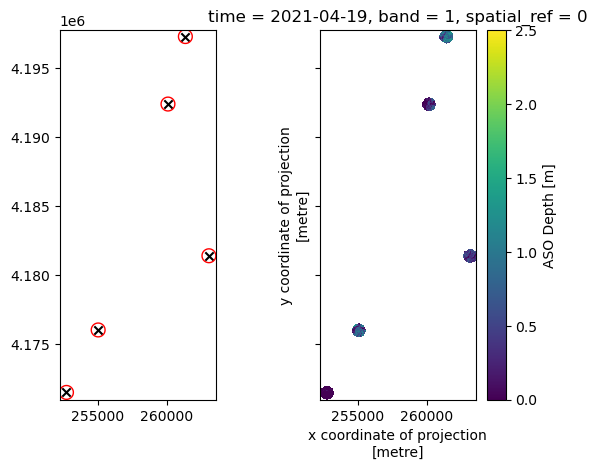

In [24]:
fig, axa = plt.subplots(1, 2, sharex=True, sharey=True)
gdf_snotel.plot(ax=axa[0], marker='x', color='black')
site_buffer.plot(ax=axa[0], marker='o', facecolor='none', edgecolor='r')
axa[0].set_aspect('equal')

aso_clipped = depth_list[0].rio.clip(site_buffer.geometry)
aso_clipped['snow_depth'].plot.imshow(vmin=0, vmax=2.5, ax=axa[1])
axa[1].set_aspect('equal')

## Plot

#### Calculate snow disappearance date separately to plot and re-plot quickly

In [25]:
# Disappearance date parameters
snow_name = 'Snow Depth'
verbose = False
day_thresh = 3

In [26]:
# %%time
# # Load all the arrays for quick plotting
# for jdx, k in enumerate(ds_dict.keys()):
#     ds_dict[k].load()
#     nwm_ds[jdx].load()

In [27]:
ds_dict.keys()

dict_keys(['iSnobal-HRRR_thickness', 'HRRR-MODIS_thickness'])

In [28]:
%%time
sdd_list = []
for jdx, (sitenum, sitename) in enumerate(zip(sitenums, sitenames)):
    # Extract SNOTEL data for this site
    snotel_df = snotel_dfs[sitename]
    print(f'\n{sitename}')

    # Extract model data for this site
    isnobal_hrrr_ts = ds_dict['iSnobal-HRRR_thickness'][sitename]
    modis_hrrr_ts = ds_dict['HRRR-MODIS_thickness'][sitename]
    # isnobal_hrrr_ts = ds_dict['iSnobal-HRRR_thickness'][:, jdx, jdx]
    # modis_hrrr_ts = ds_dict['HRRR-MODIS_thickness'][:, jdx, jdx]

    # Calculate disappearance dates
    snotel_sdd, _ = proc.calc_sdd(snotel_df['SNOWDEPTH_m'], 
                                snow_name=snow_name, 
                                verbose=verbose, 
                                day_thresh=day_thresh)
    print(f'SNOTEL: {snotel_sdd}')
    
    # Convert model data to Pandas Series
    classic_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(isnobal_hrrr_ts), index=isnobal_hrrr_ts.index),
                                snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
    print(f'Time Decay: {classic_sdd}')

    # Convert model data to Pandas Series
    modis_hrrr_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(modis_hrrr_ts), index=modis_hrrr_ts.index),
                                snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
    print(f'HRRR-MODIS: {modis_hrrr_sdd}')

    try:
        # # Resample NWM data to daily timestep to smooth hourly blips for SDD calc - handling above
        # nwm_daily = nwm_ds[jdx].resample(time='1D').mean()
        # # nwm_daily = nwm_ds[jdx]
        # nwm_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(nwm_daily.data), index=nwm_daily.time.values),
        #                                 snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
        nwm_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(nwm_daily_df[sitename]), index=nwm_daily_df.index),
                                        snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
        print(f'NWM: {nwm_sdd}')
    except:
        print("Something wrong with NWM extract")
        # add default day
        nwm_sdd = pd.Timestamp(year=WY, month=7, day=11)
              
    sdd_list.append([snotel_sdd, classic_sdd, modis_hrrr_sdd, nwm_sdd])


Cascade #2 (387)
SNOTEL: 2021-04-04 08:00:00+00:00
Time Decay: 2021-05-01 22:00:00
HRRR-MODIS: 2021-04-09 22:00:00
NWM: 2021-04-15 00:00:00

Mineral Creek (629)
SNOTEL: 2021-05-08 08:00:00+00:00
Time Decay: 2021-05-24 22:00:00
HRRR-MODIS: 2021-04-23 22:00:00
NWM: 2021-05-28 00:00:00

Molas Lake (632)
SNOTEL: 2021-05-08 08:00:00+00:00
Time Decay: 2021-05-21 22:00:00
HRRR-MODIS: 2021-05-10 22:00:00
NWM: 2021-05-20 00:00:00

Red Mountain Pass (713)
SNOTEL: 2021-06-05 08:00:00+00:00
Time Decay: 2021-06-12 22:00:00
HRRR-MODIS: 2021-05-18 22:00:00
NWM: 2021-06-15 00:00:00

Spud Mountain (780)
SNOTEL: 2021-05-08 08:00:00+00:00
Time Decay: 2021-05-28 22:00:00
HRRR-MODIS: 2021-04-26 22:00:00
NWM: 2021-06-06 00:00:00
CPU times: user 42 ms, sys: 938 μs, total: 42.9 ms
Wall time: 42.9 ms


In [29]:
# # Plotting things
# linestyles = ['-', '--']
# linewidth = 1.5
# marker = None

# snotelcolor = 'dimgray'
# isnobalcolors = ['mediumblue', 'cornflowerblue']
# nwm_color = 'salmon'#'tomato'
# alpha = 0.7
# isnobal_alpha = 0.6

# figsize = (8, 4)
# fig, ax = plt.subplots(1, figsize=figsize)
# # Plot WY time series of snow depth
# snotel_df['SNOWDEPTH_m'].plot(ax=ax,
#                                 label=f'SNOTEL',
#                                 # linestyle=(0, (3, 1, 1, 1, 1, 1)),
#                                 linewidth=linewidth/3,
#                                 color=snotelcolor,
#                                 marker='.', 
#                                 markersize=3,
#                                 # alpha=alpha
#                                 )

# isnobal_hrrr_ts.plot(ax=ax, color=isnobalcolors[0], label='Time Decay', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)
# modis_hrrr_ts.plot(ax=ax, color=isnobalcolors[1], label='HRRR-MODIS', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)

# nwm_ds[jdx].plot(ax=ax, color=nwm_color, label='NWM', linewidth=linewidth/2, 
#                linestyle='--', 
#             #    alpha=alpha
#                )

# aso_depth_ts_df[sitenames.iloc[jdx]].plot(ax=ax, marker='o', linewidth=0, label='ASO')
# sdds = sdd_list[jdx]
# snotel_sdd, classic_sdd, modis_hrrr_sdd, nwm_sdd = sdds 

# # Add callouts of disappearance dates with vertical lines
# plt.axvline(snotel_sdd, color=snotelcolor, linestyle='--', linewidth=0.75, label='SNOTEL SDD')
# plt.axvline(classic_sdd, color=isnobalcolors[0], linestyle='--', linewidth=0.75, label='Time Decay SDD')
# plt.axvline(modis_hrrr_sdd, color=isnobalcolors[1], linestyle='--', linewidth=0.75, label='HRRR-MODIS SDD')
# plt.axvline(nwm_sdd, color=nwm_color, linestyle='--', linewidth=0.75, label='NWM SDD')

# # Add arrows pointing left towards the vertical lines above, in the same color as the line
# # get fraction of max y value for the y position of the arrow
# ymax = ax.get_ylim()[1]

# plt.annotate(f'{snotel_sdd.strftime("%Y-%m-%d")}', xy=(snotel_sdd, ymax*0.2), xytext=(snotel_sdd, ymax*0.3),
#             color=snotelcolor, arrowprops=dict(color=snotelcolor, arrowstyle='->'))
# plt.annotate(f'{classic_sdd.strftime("%Y-%m-%d")}', xy=(classic_sdd, ymax*0.8), xytext=(classic_sdd, ymax*0.9),
#             color=isnobalcolors[0], arrowprops=dict(color=isnobalcolors[0], arrowstyle='->'))
# plt.annotate(f'{modis_hrrr_sdd.strftime("%Y-%m-%d")}', xy=(modis_hrrr_sdd, ymax*0.6), xytext=(modis_hrrr_sdd, ymax*0.7),
#             color=isnobalcolors[1], arrowprops=dict(color=isnobalcolors[1], arrowstyle='->'))
# plt.annotate(f'{nwm_sdd.strftime("%Y-%m-%d")}', xy=(nwm_sdd, ymax*0.4), xytext=(modis_hrrr_sdd, ymax*0.5),
#             color=nwm_color, arrowprops=dict(color=nwm_color, arrowstyle='->'))
    
# plt.legend(bbox_to_anchor=(1,1), alignment='center')
# # plt.legend(bbox_to_anchor=(1,-0.1), ncol=4, alignment='center')
# plt.title(f'{sitename} Snow Depth')
# plt.xlabel('');

In [30]:
# Plotting params
linestyles = ['-', '--']
linewidth = 1.5

snotelcolor = 'dimgray'
isnobalcolors = ['mediumblue', 'cornflowerblue']
nwm_color = 'salmon'#'tomato'
alpha = 0.7
isnobal_alpha = 0.6

figsize = (8, 4)
figsize = (12, 4)


Cascade #2 (387)

Mineral Creek (629)

Molas Lake (632)

Red Mountain Pass (713)

Spud Mountain (780)
CPU times: user 902 ms, sys: 7.54 ms, total: 909 ms
Wall time: 916 ms


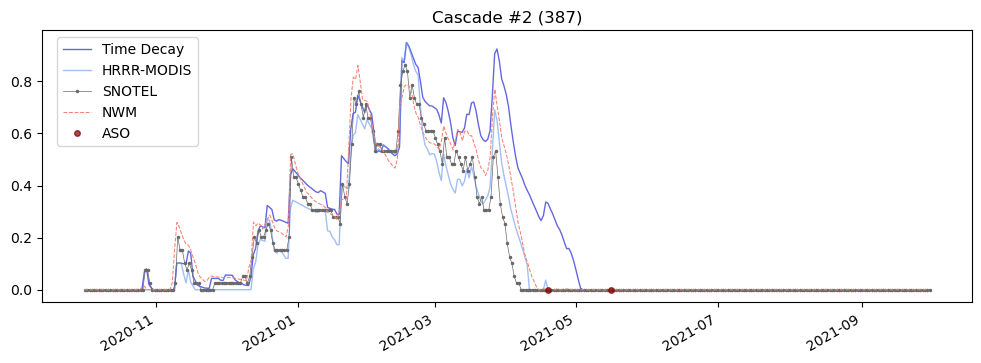

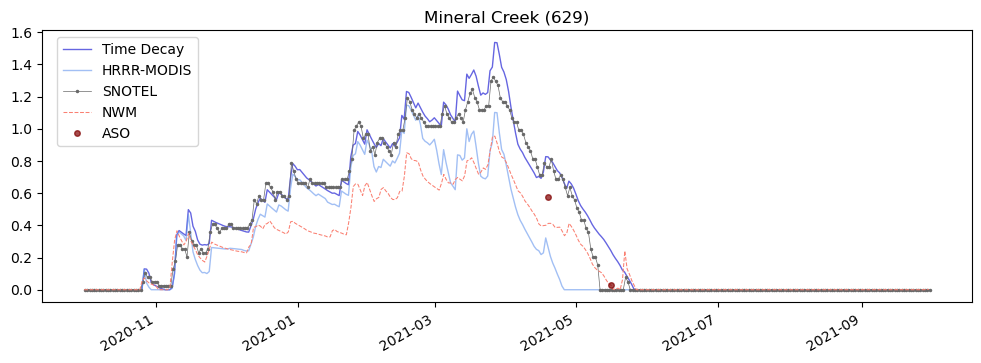

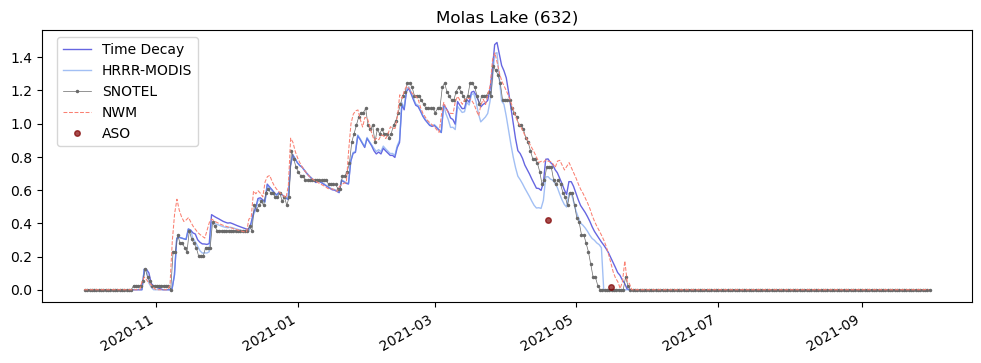

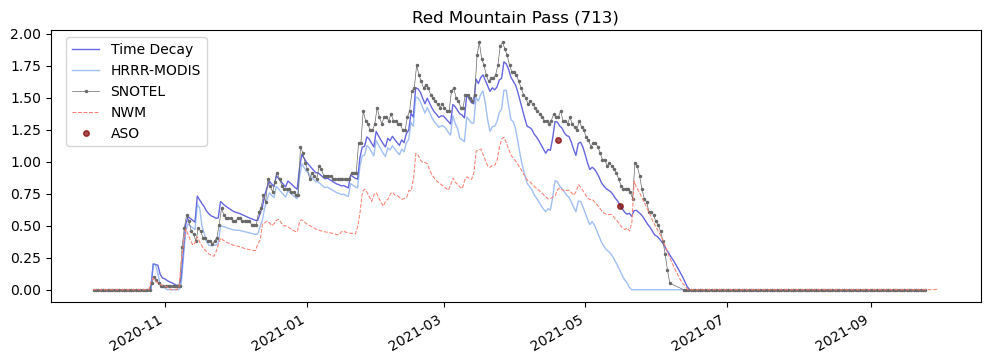

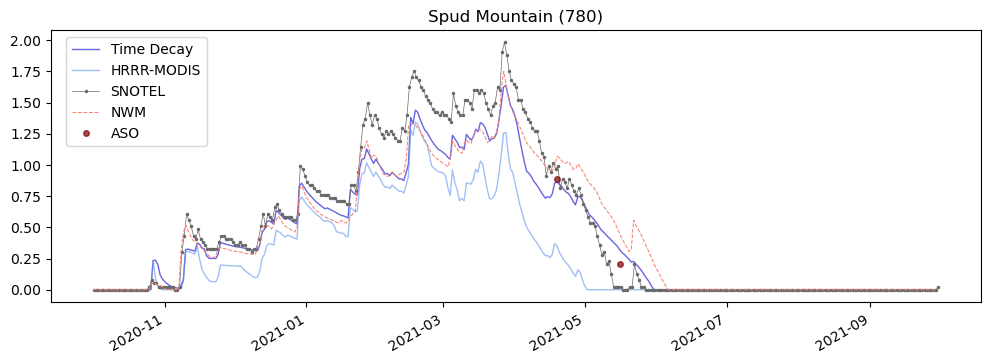

In [31]:
%%time
# No SDD version
for jdx, (sitenum, sitename) in enumerate(zip(sitenums, sitenames)):
    # Extract SNOTEL data for this site
    snotel_df = snotel_dfs[sitename]
    print(f'\n{sitename}')

    # Extract model data for this site
    isnobal_hrrr_ts = ds_dict['iSnobal-HRRR_thickness'][sitename]
    modis_hrrr_ts = ds_dict['HRRR-MODIS_thickness'][sitename]

    # Extract ASO data for this site
    # aso_depth_ts = aso_depth_ts_df[sitename]

    fig, ax = plt.subplots(1, figsize=figsize)

    isnobal_hrrr_ts.plot(ax=ax, color=isnobalcolors[0], label='Time Decay', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)
    modis_hrrr_ts.plot(ax=ax, color=isnobalcolors[1], label='HRRR-MODIS', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)

    # Plot WY time series of snow depth
    snotel_df['SNOWDEPTH_m'].plot(ax=ax, label=f'SNOTEL',
                                    # linestyle=(0, (3, 1, 1, 1, 1, 1)),
                                    linewidth=linewidth/3,
                                    color=snotelcolor, marker='.', markersize=3,
                                    )
    
    nwm_daily_df[sitename].plot(ax=ax, color=nwm_color, label='NWM', linewidth=linewidth/2, linestyle='--')
    
    aso_depth_ts_df[sitenames.iloc[jdx]].plot(ax=ax, marker='o', markersize=4, linewidth=0, label='ASO', color='maroon', alpha=alpha)

    plt.legend(bbox_to_anchor=(0.175,1), alignment='center') # for (12,4) figsize
    # plt.legend(bbox_to_anchor=(0.26,1), alignment='center') # for (8,4) figsize
    # plt.legend(bbox_to_anchor=(1,-0.1), ncol=4, alignment='center')
    plt.title(f'{sitename}')
    plt.xlabel('');


Cascade #2 (387)

Mineral Creek (629)

Molas Lake (632)

Red Mountain Pass (713)

Spud Mountain (780)


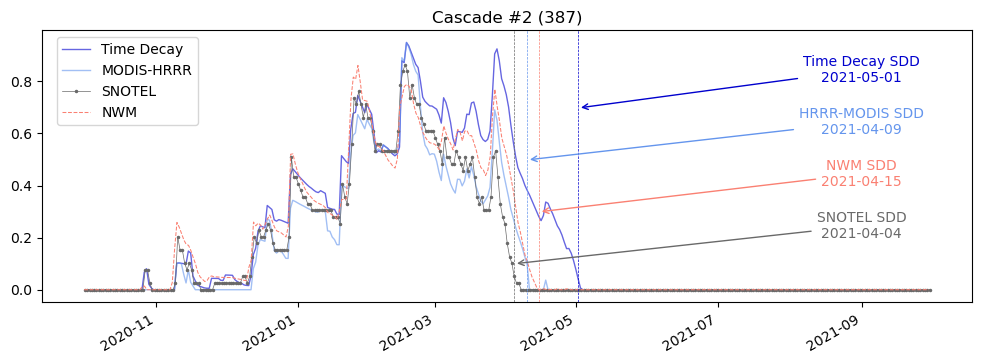

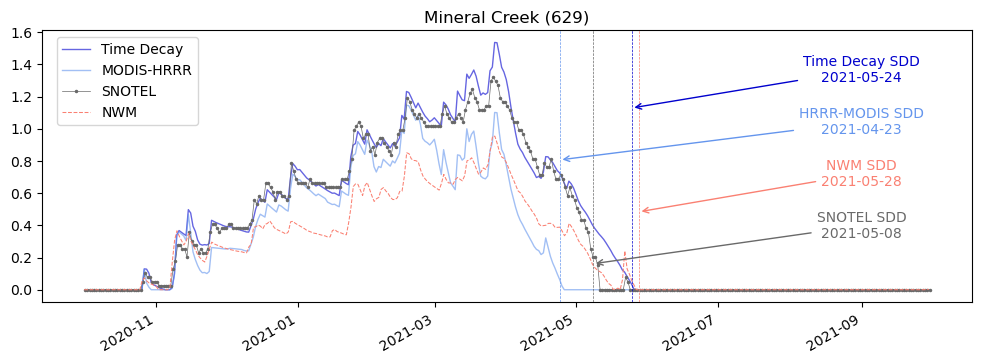

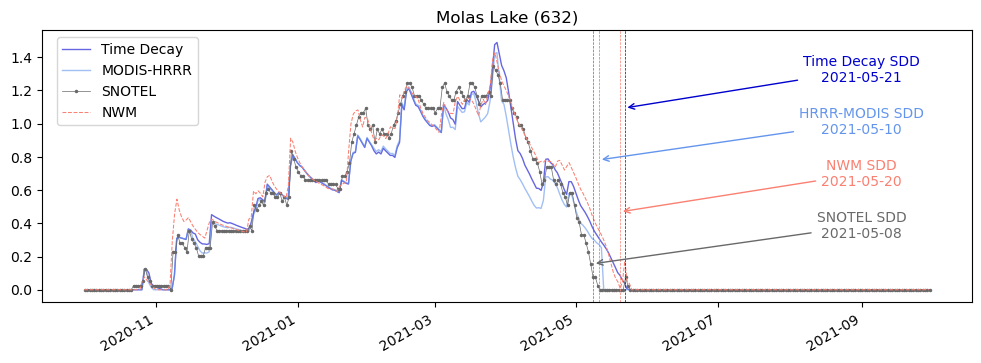

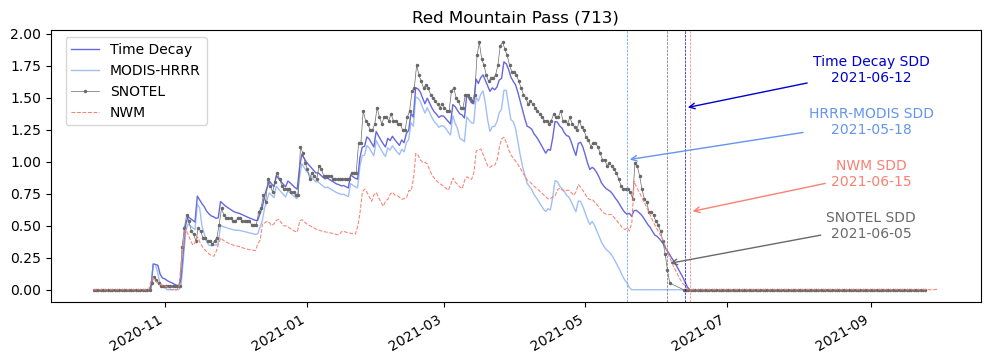

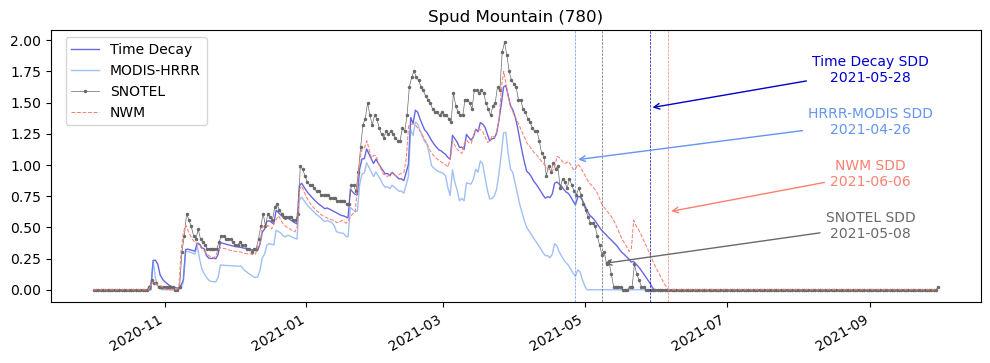

In [32]:
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    # Extract SNOTEL data for this site
    snotel_df = snotel_dfs[sitename]
    print(f'\n{sitename}')

    # Extract model data for this site
    isnobal_hrrr_ts = ds_dict['iSnobal-HRRR_thickness'][sitename]
    modis_hrrr_ts = ds_dict['HRRR-MODIS_thickness'][sitename]

    # Extract ASO data for this site
    # aso_depth_ts = aso_depth_ts_df[sitename]

    # Calculate disappearance dates
    snotel_sdd, classic_sdd, modis_hrrr_sdd, nwm_sdd = sdds 

    fig, ax = plt.subplots(1, figsize=figsize)

    isnobal_hrrr_ts.plot(ax=ax, color=isnobalcolors[0], label='Time Decay', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)
    modis_hrrr_ts.plot(ax=ax, color=isnobalcolors[1], label='MODIS-HRRR', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)

    # Plot WY time series of snow depth
    snotel_df['SNOWDEPTH_m'].plot(ax=ax, label=f'SNOTEL',
                                    # linestyle=(0, (3, 1, 1, 1, 1, 1)),
                                    linewidth=linewidth/3,
                                    color=snotelcolor, marker='.', markersize=3,
                                    )
    
    nwm_daily_df[sitename].plot(ax=ax, color=nwm_color, label='NWM', linewidth=linewidth/2, linestyle='--')
    
    # aso_depth_ts_df[sitenames.iloc[jdx]].plot(ax=ax, marker='o', markersize=4, linewidth=0, label='ASO', color='maroon', alpha=alpha)

    plt.legend(bbox_to_anchor=(0.175,1), alignment='center') # for (12,4) figsize
    # plt.legend(bbox_to_anchor=(0.26,1), alignment='center') # for (8,4) figsize
    # plt.legend(bbox_to_anchor=(1,-0.1), ncol=4, alignment='center')
    plt.title(f'{sitename}')
    plt.xlabel('');
    
    # Add callouts of disappearance dates with vertical lines
    vlinestyle = '--'
    vlinewidth = 0.5
    plt.axvline(snotel_sdd, color=snotelcolor, linestyle=vlinestyle, linewidth=vlinewidth, label='SNOTEL SDD')
    plt.axvline(classic_sdd, color=isnobalcolors[0], linestyle=vlinestyle, linewidth=vlinewidth, label='Time Decay SDD')
    plt.axvline(modis_hrrr_sdd, color=isnobalcolors[1], linestyle=vlinestyle, linewidth=vlinewidth, label='HRRR-MODIS SDD')
    plt.axvline(nwm_sdd, color=nwm_color, linestyle=vlinestyle, linewidth=vlinewidth, label='NWM SDD')

    # Add arrows pointing left towards the vertical lines above, in the same color as the line
    # get fraction of max y value for the y position of the arrow
    ymax = ax.get_ylim()[1]

    timedelta = pd.Timedelta(days=30)
    timedelta_text = pd.Timedelta(days=60)
    max_dist = pd.Timestamp(f'{snotel_sdd.year}-09-01')
    plt.annotate(f'SNOTEL SDD\n{snotel_sdd.strftime("%Y-%m-%d")}', xy=(snotel_sdd, ymax*0.1), 
                #  xytext=(snotel_sdd + timedelta_text, ymax*0.2),
                 xytext=(max_dist, ymax*0.2),
                color=snotelcolor, arrowprops=dict(color=snotelcolor, arrowstyle='->'), ha='center')
    plt.annotate(f'Time Decay SDD\n{classic_sdd.strftime("%Y-%m-%d")}', xy=(classic_sdd, ymax*0.7), 
                #  xytext=(classic_sdd + timedelta_text, ymax*0.8),
                 xytext=(max_dist, ymax*0.8),
                color=isnobalcolors[0], arrowprops=dict(color=isnobalcolors[0], arrowstyle='->'), ha='center')
    plt.annotate(f'HRRR-MODIS SDD\n{modis_hrrr_sdd.strftime("%Y-%m-%d")}', xy=(modis_hrrr_sdd, ymax*0.5), 
                #  xytext=(modis_hrrr_sdd + timedelta_text, ymax*0.6),
                 xytext=(max_dist, ymax*0.6),                 
                color=isnobalcolors[1], arrowprops=dict(color=isnobalcolors[1], arrowstyle='->'), ha='center')
    plt.annotate(f'NWM SDD\n{nwm_sdd.strftime("%Y-%m-%d")}', xy=(nwm_sdd, ymax*0.3), 
                #  xytext=(modis_hrrr_sdd + timedelta_text, ymax*0.4),
                 xytext=(max_dist, ymax*0.4),
                color=nwm_color, arrowprops=dict(color=nwm_color, arrowstyle='->'), ha='center')

In [33]:
# # These are in nwm coordinate system proj4
# for nwm in nwm_ds:
#     print(nwm.coords['x'].values)
#     print(nwm.coords['y'].values)

## One issue with df storage is that xs and ys are not kept

In [34]:
# for jdx, (x, y) in enumerate(zip(gdf_metloom.geometry.x, gdf_metloom.geometry.y)):
#     # print(x, y)
#     print(f'Diff with coords at {sitenames.iloc[jdx]}')
#     print(f'  iSnobal')
#     print(f'    x: {ds_dict['iSnobal-HRRR_thickness'].x.values[jdx] - x:.1f} m')
#     print(f'    y: {ds_dict['iSnobal-HRRR_thickness'].y.values[jdx] - y:.1f} m')
    
#     print(f'  ASO')
#     print(f'    x: {aso_depth_ts.x.values[jdx] - x:.1f} m')
#     print(f'    y: {aso_depth_ts.y.values[jdx] - y:.1f} m')

#     # print('Diff with ASO coords')

## nearest neighbor lookup is quick but the locations are up to 50 m off. averaging values over a distance would be a good idea --> recall that cell sizes for ASO are 3 m, NWM are 1 km, and iSnobal is 100 m.

# Compress these into ranges

#### find the minimum and maximum of all the snotel coords

In [35]:
depth_list = []
depth_sol_list = []
nwm_list = []
snotel_list = []

for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    depth_list.append(ds_dict['iSnobal-HRRR_thickness'][sitename])
    depth_sol_list.append(ds_dict['HRRR-MODIS_thickness'][sitename])
    nwm_list.append(nwm_daily_df[sitename])
    snotel_list.append(snotel_dfs[sitenames.iloc[jdx]]['SNOWDEPTH_m'])

In [36]:
depth_megadf = pd.concat(depth_list, axis=1)
depth_megadf.columns = sitenames

depth_sol_megadf = pd.concat(depth_sol_list, axis=1)
depth_sol_megadf.columns = sitenames

nwm_megadf = pd.concat(nwm_list, axis=1)
nwm_megadf.columns = sitenames

snotel_megadf = pd.concat(snotel_list, axis=1)
snotel_megadf.columns = sitenames

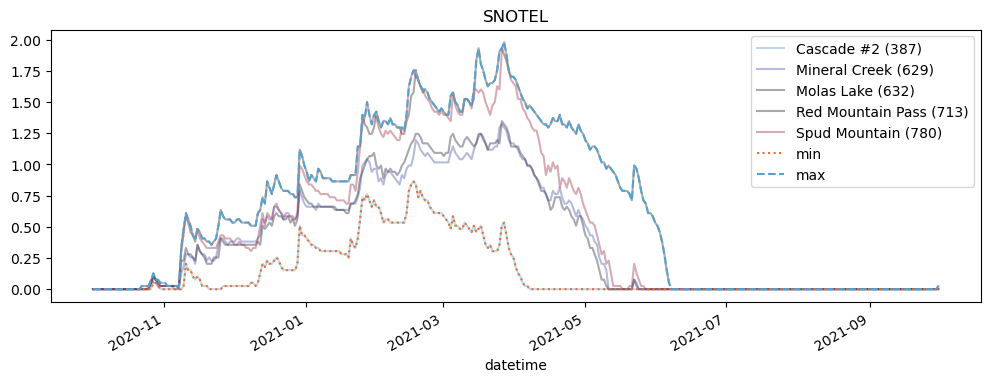

In [37]:
# snotel_megadf
fig, ax = plt.subplots(1, figsize=(12, 4))
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    snotel_megadf[sitenames.iloc[jdx]].plot(ax=ax, label=sitenames.iloc[jdx], alpha=0.4)
snotel_megadf.min(axis=1).plot(ax=ax, label='min', linestyle=':')
snotel_megadf.max(axis=1).plot(ax=ax, label='max', linestyle='--')
plt.title('SNOTEL')
plt.legend()

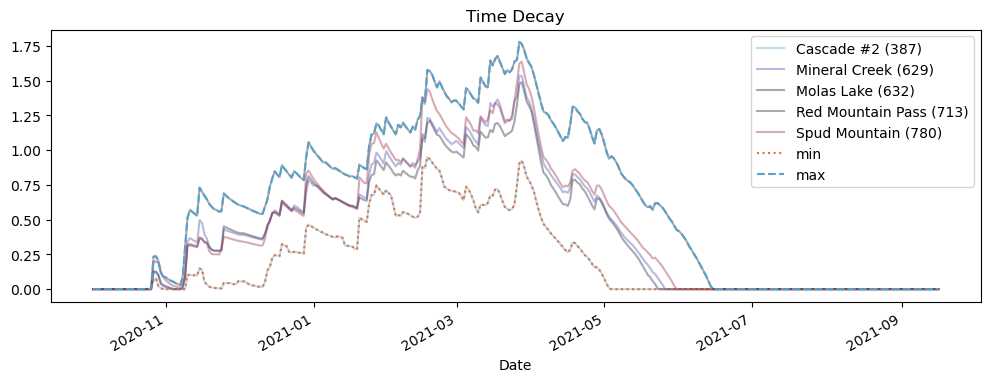

In [38]:
# depth_megadf
fig, ax = plt.subplots(1, figsize=(12, 4))
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    depth_megadf[sitenames.iloc[jdx]].plot(ax=ax, label=sitenames.iloc[jdx], alpha=0.4)
depth_megadf.min(axis=1).plot(ax=ax, label='min', linestyle=':')
depth_megadf.max(axis=1).plot(ax=ax, label='max', linestyle='--')
plt.title('Time Decay')
plt.legend()

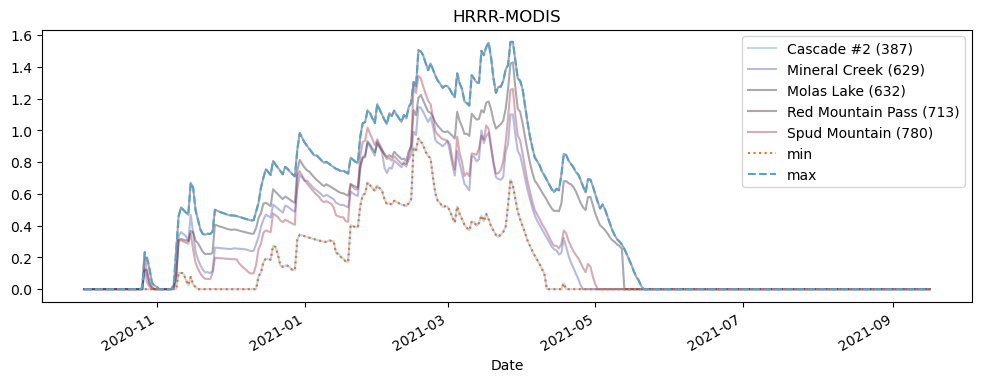

In [39]:
# depth_sol_megadf
fig, ax = plt.subplots(1, figsize=(12, 4))
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    depth_sol_megadf[sitenames.iloc[jdx]].plot(ax=ax, label=sitenames.iloc[jdx], alpha=0.4)
depth_sol_megadf.min(axis=1).plot(ax=ax, label='min', linestyle=':')
depth_sol_megadf.max(axis=1).plot(ax=ax, label='max', linestyle='--')
plt.title('HRRR-MODIS')
plt.legend()

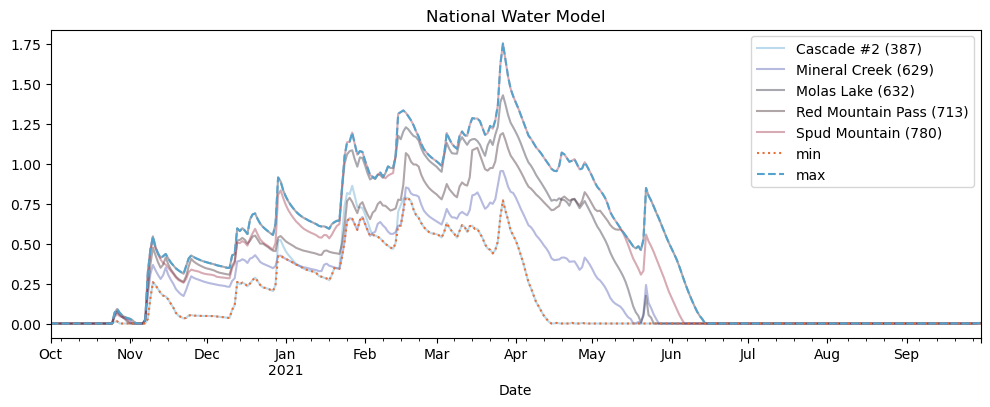

In [40]:
# nwm_megadf
fig, ax = plt.subplots(1, figsize=(12, 4))
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    nwm_megadf[sitenames.iloc[jdx]].plot(ax=ax, label=sitenames.iloc[jdx], alpha=0.4)
nwm_megadf.min(axis=1).plot(ax=ax, label='min', linestyle=':')
nwm_megadf.max(axis=1).plot(ax=ax, label='max', linestyle='--')
plt.title('National Water Model')
plt.legend()

# Plot the compressed fig

In [41]:
SMALL_SIZE = 8
MEDIUM_SIZE = 13
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [42]:
figsize

(12, 4)

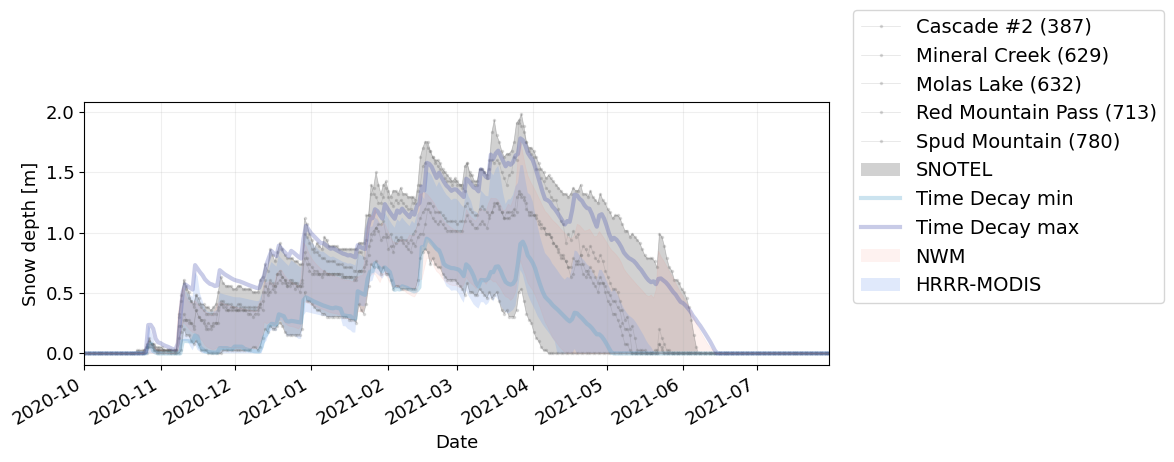

In [43]:
alpha = 0.1
fig, ax = plt.subplots(1, figsize=(12, 4.5))

snotelon = True
snotel_dotson = True
nwmon = True
timedecayon = True
modishrron = True
gridon = True

if snotelon:
    # Plot WY time series of snow depth
    if snotel_dotson:
        snotel_megadf.plot(ax=ax, legend=False,
                           linewidth=linewidth/3,
                           color=snotelcolor, marker='.', markersize=3,
                           alpha=alpha*2
                          )

    snotel_megadf.min(axis=1).plot(ax=ax, legend=False,
                                   # linewidth=0,
                                   linewidth=linewidth/3,
                                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                   alpha=alpha*2
                                  )

    snotel_megadf.max(axis=1).plot(ax=ax, legend=False,
                                   # linewidth=0,
                                   linewidth=linewidth/3,
                                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                   alpha=alpha*2
                                  )

    ax.fill_between(snotel_megadf.index, 
                    snotel_megadf.min(axis=1), 
                    snotel_megadf.max(axis=1), facecolor=snotelcolor, label='SNOTEL', 
                    alpha=alpha*3)

# iSnobal-HRRR
if timedecayon:
    # ax.fill_between(depth_megadf.index, depth_megadf.min(axis=1), depth_megadf.max(axis=1), facecolor=isnobalcolors[0], label='iSnobal-HRRR', alpha=isnobal_alpha/4)
    # depth_megadf.plot(ax=ax, label='iSnobal-HRRR', linewidth=linewidth*2, linestyle='-', 
    #                   alpha=isnobal_alpha/2
    #                  )
    depth_megadf.min(axis=1).plot(ax=ax, label='Time Decay min', linewidth=linewidth*2, linestyle='-', 
                                  alpha=isnobal_alpha/2,
                                 )
    depth_megadf.max(axis=1).plot(ax=ax, label='Time Decay max', linewidth=linewidth*2, linestyle='-', 
                                  alpha=isnobal_alpha/2
                                 )

# NWM
if nwmon:
    ax.fill_between(nwm_megadf.index, nwm_megadf.min(axis=1), nwm_megadf.max(axis=1), facecolor=nwm_color, label='NWM', alpha=alpha)
    nwm_megadf.min(axis=1).plot(ax=ax, legend=False,
                       # linewidth=0,
                       linewidth=linewidth/3,
                       color=nwm_color, marker='.', markersize=0, #markersize=3,
                       alpha=alpha
                      )

    nwm_megadf.max(axis=1).plot(ax=ax, legend=False,
                       # linewidth=0,
                       linewidth=linewidth/3,
                       color=nwm_color, marker='.', markersize=0, #markersize=3,
                       alpha=alpha
                      )
    
# HRRR-MODIS
if modishrron:
    ax.fill_between(depth_sol_megadf.index, depth_sol_megadf.min(axis=1),
                    depth_sol_megadf.max(axis=1), facecolor=isnobalcolors[1], label='HRRR-MODIS', alpha=isnobal_alpha/3)
    
# Center the plot on the data
ax.set_xlim(pd.Timestamp(f'{WY-1}-10-01'), pd.Timestamp(f'{WY}-07-30'));
ax.set_ylabel('Snow depth [m]')
plt.legend(bbox_to_anchor=(1.02, 0.2))
plt.tight_layout()
if gridon:
    ax.grid(alpha=0.2)
# plt.legend(bbox_to_anchor=(0.205,1))
# plt.legend(bbox_to_anchor=(0.195,1))
outname = f'{basin}_ts.png'
# outname = f'{basin}_snotel_nwm_ts.png'
# outname = f'{basin}_snotel.png'
# plt.savefig(outname, dpi=300)

In [44]:
# import hvplot.pandas  # noqa

# pd.options.plotting.backend = 'holoviews'
# depth_megadf.plot()

In [45]:
depth_sol_megadf.max()

site_name
Cascade #2 (387)           0.948796
Mineral Creek (629)        1.146141
Molas Lake (632)           1.428242
Red Mountain Pass (713)    1.557213
Spud Mountain (780)        1.343520
dtype: float64

In [46]:
depth_sol_megadf.idxmax()

site_name
Cascade #2 (387)          2021-02-16 22:00:00
Mineral Creek (629)       2021-02-16 22:00:00
Molas Lake (632)          2021-03-27 22:00:00
Red Mountain Pass (713)   2021-03-27 22:00:00
Spud Mountain (780)       2021-02-16 22:00:00
dtype: datetime64[ns]

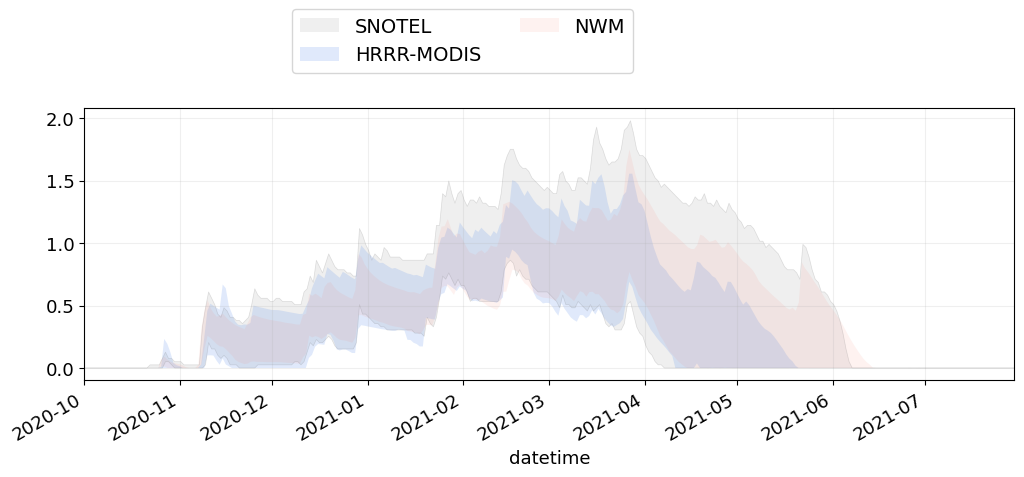

In [47]:
alpha = 0.1
fig, ax = plt.subplots(1, figsize=figsize)


# # Plot WY time series of snow depth
# snotel_megadf.plot(ax=ax, legend=False,
#                    linewidth=linewidth/3,
#                    color=snotelcolor, marker='.', markersize=3,
#                    alpha=alpha*2
#                   )

snotel_megadf.min(axis=1).plot(ax=ax, legend=False,
                   # linewidth=0,
                   linewidth=linewidth/3,
                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                   alpha=alpha*2
                  )

snotel_megadf.max(axis=1).plot(ax=ax, legend=False,
                   # linewidth=0,
                   linewidth=linewidth/3,
                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                   alpha=alpha*2
                  )

ax.fill_between(snotel_megadf.index, 
                snotel_megadf.min(axis=1), 
                snotel_megadf.max(axis=1), facecolor=snotelcolor, label='SNOTEL', 
                alpha=alpha)

# iSnobal-HRRR
# ax.fill_between(depth_megadf.index, depth_megadf.min(axis=1), depth_megadf.max(axis=1), facecolor=isnobalcolors[0], label='iSnobal-HRRR', alpha=isnobal_alpha/4)
# depth_megadf.plot(ax=ax, label='iSnobal-HRRR', linewidth=linewidth*2, linestyle='-', 
#                     alpha=isnobal_alpha/2
#                  )
# depth_megadf.min(axis=1).plot(ax=ax, label='Time Decay min', linewidth=linewidth*2, linestyle='-', 
#                     alpha=isnobal_alpha/2
#                  )
# depth_megadf.max(axis=1).plot(ax=ax, label='Time Decay max', linewidth=linewidth*2, linestyle='-', 
#                     alpha=isnobal_alpha/2
#                  )

# HRRR-MODIS
ax.fill_between(depth_sol_megadf.index, depth_sol_megadf.min(axis=1),depth_sol_megadf.max(axis=1), facecolor=isnobalcolors[1], label='HRRR-MODIS', alpha=isnobal_alpha/3)
# depth_sol_megadf.plot(ax=ax, label='HRRR-MODIS', linewidth=linewidth/3*2, linestyle='--', 
#                       color=sns.color_palette('icefire'),
#                      )
# depth_sol_megadf.min(axis=1).plot(ax=ax, label='HRRR-MODIS min', linewidth=linewidth/3*2, linestyle='--', 
#                                   color=sns.color_palette('icefire'),
#                                  )
# depth_sol_megadf.max(axis=1).plot(ax=ax, label='HRRR-MODIS max', linewidth=linewidth/3*2, linestyle='--',
#                                  )


# NWM
ax.fill_between(nwm_megadf.index, nwm_megadf.min(axis=1), nwm_megadf.max(axis=1), facecolor=nwm_color, label='NWM', alpha=alpha)

# Center the plot on the data
ax.set_xlim(pd.Timestamp(f'{WY-1}-10-01'), pd.Timestamp(f'{WY}-07-30'));
if gridon:
    ax.grid(alpha=0.2)
# plt.legend()
# plt.legend(bbox_to_anchor=(0,-0.2), ncols=6)
plt.legend(bbox_to_anchor=(0.6,1.4), ncols=2)
# plt.tight_layout()